In [20]:
!pip install hypll geoopt -q

In [21]:
import os
import csv
import time
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

import nibabel as nib
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import geoopt


from sklearn.model_selection import train_test_split

In [22]:
class Config:

    # A portion of data is only taken
    train_dir = '/kaggle/input/spleen-decathlon-dataset/Task09_Spleen/imagesTr'
    # test_dir = '/kaggle/input/spleen-decathlon-dataset/Task09_Spleen/imagesTs'
    labels_dir = '/kaggle/input/spleen-decathlon-dataset/Task09_Spleen/labelsTr'

    vol_paths = list()
    seg_paths = list()

    vols_count = None
    segs_count = None

    window = (40,60)

    batch_size = 1
    learning_rate = 10e-3

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [24]:
for file in os.listdir(Config.train_dir):
    if file.endswith('.nii'):
     
        Config.vol_paths.append(os.path.join(Config.train_dir,file))
        Config.seg_paths.append(os.path.join(Config.labels_dir,file))

Config.vols_count = len(Config.vol_paths)
Config.segs_count = len(Config.seg_paths)

print('Total CT Scan Volumes for Train:', Config.vols_count)
print('Total Segmentation masks:', Config.segs_count)

Total CT Scan Volumes for Train: 41
Total Segmentation masks: 41


In [25]:
path = Config.vol_paths[1]
data = nib.load(path).get_fdata().transpose(2,1,0)
seg = nib.load(Config.seg_paths[1]).get_fdata().transpose(2,1,0)

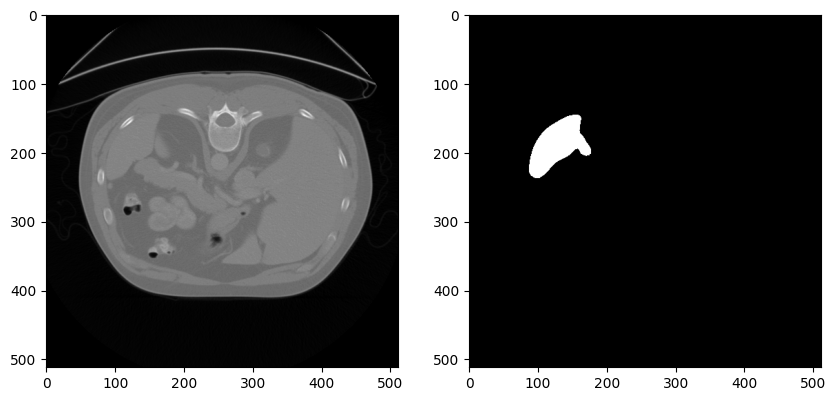

In [26]:
_, axes = plt.subplots(1,2, figsize = (10,5))
axes[0].imshow(data[80], cmap = 'gray')
axes[1].imshow(seg[80], cmap = 'gray')
plt.show()

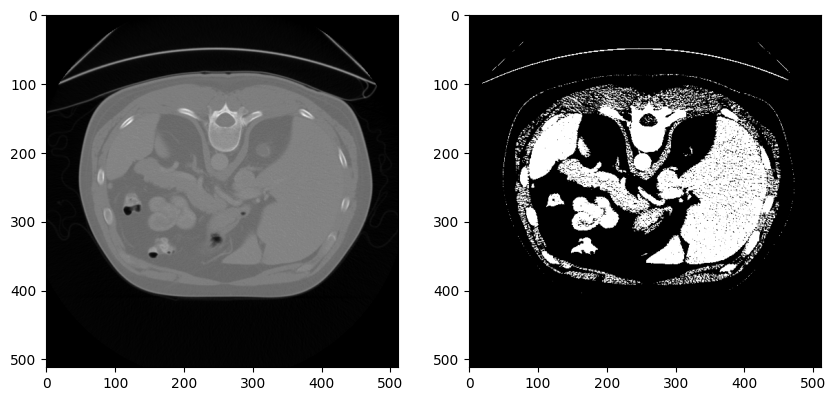

In [27]:
win_img = np.clip(data[80], 40,60)
_, axes = plt.subplots(1,2, figsize = (10,5))
axes[0].imshow(data[80], cmap = 'gray')
axes[1].imshow(win_img, cmap = 'gray')
plt.show()

In [28]:
norm_img = (win_img - 40)/ 20
norm_img.max()

1.0

In [29]:
def preprocess(ct_scan: np.ndarray, window: tuple = (40,60)) -> np.ndarray:
    """Applying windowing for given Data and Normalizing"""
    min_value, max_value = window

    ct_scan = cv2.resize(ct_scan,(256,256),interpolation = cv2.INTER_AREA)
    # Apply windowing
    windowed_ct = np.clip(ct_scan, min_value, max_value)

    # Normalize to 0-1
    windowed_ct = ((windowed_ct - min_value) / (max_value - min_value))

    return windowed_ct

In [30]:
class spleenDataset(Dataset):
    def __init__(self, vol_paths, seg_paths, transform = None):

        self.vol_paths = vol_paths
        self.seg_paths = seg_paths
        self.transform = transform
        self.slice_info = self._get_slice_info()

    def _get_slice_info(self):

        slice_info = []
        for vol_idx, vol_path in enumerate(self.vol_paths):
            vol = nib.load(vol_path)
            num_slices = vol.shape[2]
            for slice_idx in range(num_slices):
                slice_info.append((vol_idx, slice_idx))
        return slice_info

    def __len__(self):

         return len(self.slice_info)

    def __getitem__(self, idx):

         vol_idx, slice_idx = self.slice_info[idx]

         vol = nib.load(self.vol_paths[vol_idx]).get_fdata()
         seg = nib.load(self.seg_paths[vol_idx]).get_fdata()

         if self.transform:
             vol = self.transform(vol)
         Y = cv2.resize(seg[:,:,slice_idx],(256,256),interpolation=cv2.INTER_AREA)
         X = np.expand_dims(vol[:,:,slice_idx], axis = 0)
         Y = np.expand_dims(Y, axis = 0)

         return torch.tensor(X, dtype=torch.float32), torch.tensor(Y,dtype=torch.float32)

In [31]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(Config.vol_paths, Config.seg_paths, test_size = 0.2, random_state = 42)

In [32]:
train_dataset = spleenDataset(Xtrain, Ytrain, transform = preprocess)
trainloader = DataLoader(train_dataset, batch_size = Config.batch_size, shuffle = True)

test_dataset = spleenDataset(Xtest, Ytest, transform = preprocess)
testloader = DataLoader(test_dataset, batch_size = Config.batch_size, shuffle = True)

In [33]:
import hypll.nn as hnn
from hypll.tensors.manifold_tensor import ManifoldTensor
from hypll.manifolds.poincare_ball import Curvature, PoincareBall

ball = PoincareBall(Curvature(1.0))


def logmap0(y, c = torch.tensor(1.0), dim=-1):
    y_tensor = y.tensor if isinstance(y, ManifoldTensor) else y  # Extract tensor if ManifoldTensor
    y_norm_c_sqrt = torch.linalg.norm(y_tensor, dim=dim, keepdim=True).clamp_min(1e-15) * torch.sqrt(c)
    return torch.atanh(y_norm_c_sqrt) * y_tensor / y_norm_c_sqrt

def project(x: torch.Tensor, c: torch.Tensor, dim: int = -1, eps: float = -1.0):
    if eps < 0:
        if x.dtype == torch.float32:
            eps = 4e-3
        else:
            eps = 1e-5
    maxnorm = (1 - eps) / ((c + 1e-15) ** 0.5)
    maxnorm = torch.where(c.gt(0), maxnorm, c.new_full((), 1e15))
    norm = x.norm(dim=dim, keepdim=True, p=2).clamp_min(1e-15)
    cond = norm > maxnorm
    projected = x / norm * maxnorm
    return torch.where(cond, projected, x)

def expmap0(v: torch.Tensor, c: torch.Tensor = torch.tensor(1.0), dim: int = -1):
    v_norm_c_sqrt = v.norm(dim=dim, keepdim=True).clamp_min(1e-15) * torch.sqrt(c)
    return project(torch.tanh(v_norm_c_sqrt) * v / v_norm_c_sqrt, c, dim=dim)

class HConvTranspose2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0):
        super().__init__()
        self.conv_transpose = nn.ConvTranspose2d(
            in_channels, out_channels, kernel_size, stride, padding, output_padding
        )

    def forward(self, x):
        # Convert to Euclidean space
        x_euclidean = logmap0(x)  # Logarithmic map (Hyperbolic → Euclidean)

        # Apply standard transposed convolution
        x_upsampled = self.conv_transpose(x_euclidean)

        # Convert back to Hyperbolic space
        x_hyperbolic = expmap0(x_upsampled) 

        return ManifoldTensor(x_hyperbolic, ball)


In [34]:
def cat(x: list[ManifoldTensor, ManifoldTensor], dim):
    
    if x[1].dim() ==3:
        x[1] = x[1].unsqueeze(0)

    # Ensure concatenation along correct dimension
    x = torch.cat((x[0].tensor, x[1].tensor), dim=dim)
    x = TangentTensor(x, man_dim=1, manifold=ball)

    return ball.expmap(x)

In [35]:
class hunet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3
        self.e11 = hnn.HConvolution2d(1, 64,manifold=ball, kernel_size=3, padding=1) # output: 570x570x64
        self.e12 = hnn.HConvolution2d(64, 64,manifold=ball, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = hnn.HMaxPool2d(manifold=ball,kernel_size=2, stride=2) # output: 284x284x64
        self.relu=hnn.HReLU(ball)

        # input: 284x284x64
        self.e21 = hnn.HConvolution2d(64, 128, manifold=ball,kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = hnn.HConvolution2d(128, 128,manifold=ball, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = hnn.HMaxPool2d(manifold=ball,kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = hnn.HConvolution2d(128, 256,manifold=ball, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = hnn.HConvolution2d(256, 256,manifold=ball, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = hnn.HMaxPool2d(manifold=ball,kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = hnn.HConvolution2d(256, 512,manifold=ball, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = hnn.HConvolution2d(512, 512,manifold=ball, kernel_size=3, padding=1) # output: 64x64x512
        self.pool4 = hnn.HMaxPool2d(manifold=ball,kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = hnn.HConvolution2d(512, 1024,manifold=ball, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = hnn.HConvolution2d(1024, 1024, manifold=ball,kernel_size=3, padding=1) # output: 28x28x1024


        # Decoder
        self.upconv1 = HConvTranspose2d(1024, 512,kernel_size=2, stride=2)
        self.d11 = hnn.HConvolution2d(1024, 512,manifold= ball, kernel_size=3, padding=1)
        self.d12 = hnn.HConvolution2d(512, 512,manifold= ball, kernel_size=3, padding=1)

        self.upconv2 = HConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = hnn.HConvolution2d(512, 256,manifold= ball, kernel_size=3, padding=1)
        self.d22 = hnn.HConvolution2d(256, 256,manifold= ball,kernel_size=3, padding=1)

        self.upconv3 = HConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = hnn.HConvolution2d(256, 128,manifold= ball, kernel_size=3, padding=1)
        self.d32 = hnn.HConvolution2d(128, 128,manifold= ball, kernel_size=3, padding=1)

        self.upconv4 = HConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = hnn.HConvolution2d(128, 64,manifold= ball,kernel_size=3, padding=1)
        self.d42 = hnn.HConvolution2d(64, 64,manifold=ball, kernel_size=3, padding=1)

        # Output layer
        self.outconv = hnn.HConvolution2d(64, n_class, kernel_size=1,manifold= ball)

    def forward(self, x):
        # Encoder
        
        x   =  self.relu(self.e11(x))
        x1  =  self.relu(self.e12(x))
        x   = self.pool1(x1)

        x   =  self.relu(self.e21(x))
        x2 =  self.relu(self.e22(x))
        x = self.pool2(x2)

        x =  self.relu(self.e31(x))
        x3 =  self.relu(self.e32(x))
        x = self.pool3(x3)

        x =  self.relu(self.e41(x))
        x4 =  self.relu(self.e42(x))
        x = self.pool4(x4)

        x = self.relu(self.e51(x))
        x =  self.relu(self.e52(x))
        
        # Decoder
        x = self.upconv1(x)
        x = cat([x, x4], dim=1)
        x =  self.relu(self.d11(x))
        x =  self.relu(self.d12(x))

        x = self.upconv2(x)
        x = cat([x, x3], dim=1)
        x = self.relu(self.d21(x))
        x =  self.relu(self.d22(x))

        x = self.upconv3(x)
        x = cat([x, x2], dim=1)
        x = self.relu(self.d31(x))
        x =  self.relu(self.d32(x))

        x = self.upconv4(x)
        x = cat([x, x1], dim=1)
        x =  self.relu(self.d41(x))
        x = self.relu(self.d42(x))

        return self.outconv(x)

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from hypll.tensors import ManifoldTensor
from hypll.manifolds.poincare_ball import Curvature, PoincareBall
#from hypll.utils import check_dims_with_broadcasting, dist

In [37]:
''''import torch  # Make sure you import torch

def dist(x, y, c, dim, keepdim=False):
    """
    Compute the hyperbolic distance between points x and y in the Poincare ball.

    Args:
        x: First point (Tensor).
        y: Second point (Tensor).
        c: Curvature (callable that returns a tensor or float).
        dim: Dimension along which to compute the distance.
        keepdim: Whether to keep the dimension being reduced.

    Returns:
        Hyperbolic distance (Tensor).
    """

    c_val = c()  # Get the curvature value (could be a tensor or float)

    if isinstance(c_val, torch.Tensor): #check if c_val is a tensor
        sqrt_c = torch.sqrt(c_val) #perform torch.sqrt
    else:
        sqrt_c = torch.sqrt(torch.tensor(c_val)) #convert to tensor and perform torch.sqrt

    return (
        2
        / sqrt_c
        * (sqrt_c * mobius_add(-x, y, c, dim=dim).norm(dim=dim, keepdim=keepdim)).atanh()
    )''''

SyntaxError: unterminated string literal (detected at line 29) (<ipython-input-37-d7ad72f10392>, line 29)

In [ ]:
''''class HyperbolicCrossEntropyLoss(nn.Module):
    def __init__(self, c=1.0):
        """
        Hyperbolic Cross-Entropy Loss
        :param c: Curvature of the Poincare ball
        """
        super(HyperbolicCrossEntropyLoss, self).__init__()
        self.manifold = PoincareBall(c=lambda: c)

    def forward(self, logits, targets):
        """
        Compute Hyperbolic Cross-Entropy Loss
        :param logits: Model output logits [batch_size, num_classes, height, width]
        :param targets: Ground truth labels [batch_size, height, width]
        :return: Hyperbolic cross-entropy loss
        """

        # Ensure logits is a PyTorch tensor before conversion
        if isinstance(logits, ManifoldTensor):
            logits = logits.tensor  # Extract raw tensor

        logits = logits.float()  # Convert to float tensor

        # Ensure targets are long type for cross entropy
        targets = targets.long()

        # Convert logits to hyperbolic space
        logits_hyper = ManifoldTensor(logits, manifold=self.manifold)

        # Compute hyperbolic distances to the origin
        zero_point = torch.zeros_like(logits, device=logits.device)
        zero_hyper = ManifoldTensor(zero_point, manifold=self.manifold)

        d_x_0 = self.manifold.dist(logits_hyper, zero_hyper)

        # Apply softmax over negative distances
        probs = F.softmax(-(d_x_0), dim=1)

        # Compute log-probabilities and cross-entropy loss
        loss = F.nll_loss(torch.log(probs.clamp(min=1e-9)), targets)

        return loss'''

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HyperUL(nn.Module):
    def __init__(self, t=2.718, hr=1.0, c=1.0):
        """
        Hyperbolic Uncertainty Loss (HyperUL)
        :param t: Controls uncertainty weight scaling
        :param hr: Hyperparameter for Online High Uncertainty Example Mining (OHUEM)
        :param c: Curvature of the Poincare ball
        """
        super(HyperUL, self).__init__()
        self.t = t
        self.hr = hr
        self.manifold = PoincareBall(Curvature(c))

    def forward(self, logits, targets):
        """
        Compute Hyperbolic Uncertainty Loss
        :param logits: Model output logits [batch_size, num_classes, height, width] (for multi-class)
                      or [batch_size, 1, height, width] (for binary segmentation)
        :param targets: Ground truth labels [batch_size, height, width]
        :param hyper_embeddings: Hyperbolic embeddings [batch_size, feature_dim, height, width]
        :return: HyperUL loss
        """
        #print("logitsshape:",logits.shape)
        #print("targetsshape:"targets.shape)
        probs=torch.softmax(logits.tensor,dim=1)
        probs_2 = torch.argmax(probs,dim=1)
        #print("Shape of probs:",probs.shape)
        if targets.dim()== 4:
            targets=targets.squeeze(1)
        print('target shape after squeezing:',targets.shape)

        
        loss = F.cross_entropy(logits.tensor, targets.long())
     

        # Compute hyperbolic distances
        d_x_0 = self.manifold.dist(ManifoldTensor(probs_2, manifold = self.manifold),
            ManifoldTensor(torch.zeros_like(probs_2 , device = device), manifold = self.manifold)
        )

        du = torch.min(d_x_0)

        # Compute uncertainty weight
        d = d_x_0 / (du + 1e-9)  # Avoid division by zero
        uncertainty_weight = 1 / torch.log(self.t + d + 1e-9)

        # Compute OHUEM threshold
        dhr_c = d_x_0 + self.hr * (du - d_x_0)

        # Apply loss only where uncertainty criterion is met
        mask = (d_x_0 <= dhr_c).float()
        loss = (uncertainty_weight * loss * mask).mean()

        return loss


In [48]:
def dice_coefficient(pred, target, smooth = 1e-6):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum(dim=(2,3))
    union = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))

    dice_score = (2. * intersection + smooth) / (union + smooth)
    return dice_score.mean()

def dice_loss(pred, target, smooth = 1e-6):
    return 1 - dice_coefficient(pred, target)

In [49]:
def mIou(y_true, y_pred):
    intersection = torch.sum(y_true * y_pred)
    union = torch.sum(y_true) + torch.sum(y_pred)
    
    if union == 0:
        return 1.0 if intersection == 0 else 0.0  # Handle edge case
    
    return intersection / union

In [50]:
def precision(preds, targets, threshold=0.5, eps=1e-7):

    # Convert probabilities to binary predictions
    preds = (preds > threshold).float()

    # Flatten tensors
    preds = preds.view(-1)
    targets = targets.view(-1)

    # Compute True Positives (TP) and False Positives (FP)
    tp = (preds * targets).sum()  # True Positives
    fp = (preds * (1 - targets)).sum()  # False Positives

    # Compute Precision
    precision = tp / (tp + fp + eps)

    return precision.item()

In [51]:
def recall(preds, targets, threshold=0.5, eps=1e-7):
    # Convert probabilities to binary predictions
    preds = (preds > threshold).float()

    # Flatten tensors
    preds = preds.view(-1)
    targets = targets.view(-1)

    # Compute True Positives (TP) and False Negatives (FN)
    tp = (preds * targets).sum()  # True Positives
    fn = ((1 - preds) * targets).sum()  # False Negatives

    # Compute Recall
    recall = tp / (tp + fn + eps)

    return recall.item()

In [52]:
from hypll.tensors import TangentTensor, manifold_parameter
  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = hunet(n_class=2).to(device)

# Loss and optimizer
criterion = HyperUL()
optimizer = geoopt.optim.RiemannianAdam(
    [param.tensor if isinstance(param, manifold_parameter.ManifoldParameter) else param for param in model.parameters()],
    lr=10e-3
)

In [53]:
def perform_validation(model,test_dataloader, device):
    model.eval()  # Set model to evaluation mode
    val_loss,val_dice, val_miou, val_recall,val_precision = 0,0,0,0,0

    val_iterator = tqdm(test_dataloader, desc=f"Validation...", leave = False)
    with torch.no_grad():
        for inputs, masks in val_iterator:
            inputs = inputs.to(device)
            masks = masks.to(device)

            tangents = TangentTensor(inputs, man_dim=1, manifold=ball)
            inputs = ball.expmap(tangents)
            
            outputs = model(inputs)

            loss = criterion(outputs, masks)
            outputs = outputs.tensor
            
            dice = dice_coefficient(outputs, masks)
            
            outputs = torch.argmax(outputs, dim=1)  # Convert logits to class labels
            targets = targets.squeeze(1)  # Ensure targets are 2D if they have an extra channel
            #assert outputs.shape == targets.shape, 
            
            precision_score = precision(outputs, masks)
            recall_score = recall(outputs, masks)
            miou_score = mIou(outputs, masks)
                
            val_loss += loss
            val_dice += dice
            val_miou += miou_score
            val_recall += recall_score
            val_precision = precision_score

    return (val_loss/ len(test_dataloader)),(val_dice/ len(test_dataloader)), (val_miou/ len(test_dataloader)), (val_recall/ len(test_dataloader)),(val_precision/ len(test_dataloader))


In [ ]:
# Training loop
num_epochs = 100

for epoch in range (num_epochs):
    model.train()
    
    best_dice_coefficient = 0
    total_training_time = 0
    log_file = "HUNet_hyperul_256.csv"  
    log_fields = ["epoch", "time", "train_loss", "val_loss", "dice_train", "dice_val", "mIou_train", "mIou_val", "precision_train", "precision_val", "recall_train", "recall_val",]

    # Initialize logging file
    with open(log_file, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=log_fields)
        writer.writeheader()

    train_iterator = tqdm(enumerate(trainloader), total=len(trainloader), desc=f"Epoch {epoch+1}")

    start_time = time.time()
    train_loss = 0.0
    train_dice = 0
    train_miou = 0
    train_precision = 0
    train_recall = 0

    for i, (inputs, masks) in train_iterator:
        inputs = inputs.to(device)
        masks = masks.to(device)

        tangents = TangentTensor(inputs, man_dim=1, manifold=ball)
        inputs = ball.expmap(tangents)
        
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        outputs = outputs.tensor
        
        dice = dice_coefficient(outputs, masks)
        outputs = torch.argmax(outputs, dim=1)  # Convert logits to class labels
        #masks = masks.squeeze(1)  # Ensure targets are 2D if they have an extra channel
        #assert outputs.shape == targets.shape, 
        precision_score = precision(outputs, masks)
        recall_score = recall(outputs, masks)
        miou_score = mIou(outputs, masks)

        # Update metrics
        train_loss += loss
        train_dice += dice
        train_miou += miou_score
        train_recall += recall_score
        train_precision = precision_score

        train_iterator.set_postfix({
            'loss': f"{train_loss/(i+1):.4f}",
            'dice': f"{train_dice/(i+1):.4f}",
            'miou': f"{train_miou/(i+1):.4f}"
        })

  
    val_loss,val_dice, val_miou, val_recall,val_precision = perform_validation(model, testloader, device)

    if val_dice > best_dice_coefficient:
        torch.save(model.state_dict(), 'hunet_hyperul_256.pt')
        best_dice_coefficient = val_dice

    epoch_time = time.time() - start_time
    total_training_time += epoch_time

    # Log the metrics
    with open(log_file, 'a', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=log_fields)
        writer.writerow({
            "epoch": epoch,
            "time": epoch_time,
            "train_loss": train_loss / (i + 1),
            "val_loss": val_loss,
            "dice_train": train_dice / (i + 1),
            "dice_val": val_dice,
            "mIou_train": train_miou / (i + 1),
            "mIou_val": val_miou,
            "precision_train": train_precision / (i + 1),
            "precision_val": val_precision,
            "recall_train": train_recall / (i + 1),
            "recall_val": val_recall
            
        })

    print(f"Training Complete in {total_training_time:.4f}s with {total_training_time/100:.4f}s per epoch.")